In [1]:
# could also include topography from National Land Coverage Database:
# https://pubs.usgs.gov/fs/2012/3020/

## VERY NICE VIDEO ON FORECASTING AND BUILDING SAS NN MODEL:
# https://blogs.sas.com/content/subconsciousmusings/2018/07/05/deep-learning-forecasts-solar-power/

# Another source for wind speed and power energy prediction
# https://github.com/ShashwatArghode/Wind-Energy-Prediction-using-LSTM/blob/master/CSE%20523%20Project%20Report.pdf

In [2]:
# import libraries and magic
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import spatial
import re
import geopandas
import requests
import glob
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

years = [2015, 2016, 2017, 2018]

In [3]:
# Load injested and cleaned wind energy generation data
def load_wind_farm_data(years):
    metadf = pd.DataFrame(columns = ['station_name','latitude','longitude'])
    datadf = pd.DataFrame(columns = ['station_name','hour','date','datetime','power_output','pred_power_output','max_power_output','pmax_power_output','pred_pmax_power_output','latitude','longitude'])
    for year in years:
        # wind farm station metadata
        df1 = pd.read_csv('4cleaned_wind_power_data/compiled_wind_farm_station_metadata_' + str(year) + '.csv')
        df1.drop(columns=[
            'Unnamed: 0',
            'station_alt_name',
            'station_type',
            'in_dataset'],
            inplace=True)
        df1.set_index('station_name', inplace=True)

        # wind power data
        df2 = pd.read_csv('4cleaned_wind_power_data/compiled_wind_power_data_' + str(year) + '.csv')
        df2.drop(columns=['Unnamed: 0'],inplace=True)
        df2.loc[:,'date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')
        df2.loc[:,'datetime'] = pd.to_datetime(df2['datetime'], format='%Y-%m-%d %H:%M:%S')
        df2.set_index('station_name', inplace=True)

        # Join em up
        df2 = df2.join(df1).reset_index()
        df1.reset_index(inplace=True)
        metadf = pd.concat((metadf, df1), axis=0)
        datadf = pd.concat((datadf, df2), axis=0)
    
    # filter to those stations that contain data for all four years
    nentries = metadf.groupby('station_name')['latitude'].count().max()
    stations = metadf.groupby('station_name')['latitude'].agg({
                                              'latitude': lambda x: x.count().max()})
    stations = list(stations.loc[stations['latitude']==nentries].index)
    true_metadf = metadf[metadf['station_name'].isin(stations)]
    true_metadf = true_metadf.drop_duplicates()
    true_datadf = datadf[datadf['station_name'].isin(stations)]
    
    return true_metadf, true_datadf

In [4]:
wind_farm_stns_df, wind_power_df = load_wind_farm_data(years)

C:\Users\alacroix367\Miniconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [5]:
display(wind_farm_stns_df.head(3))
display(wind_power_df.head(3))
print(wind_farm_stns_df.shape)
print(wind_power_df.shape)

,station_name,latitude,longitude
0,ADELAIDE,43.100099,-81.634304
1,AMARANTH,44.104724,-80.618731
2,BLAKE,43.071470,-81.594138


,station_name,hour,date,datetime,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output,latitude,longitude
0,ADELAIDE,0,2015-01-01,2015-01-01 00:00:00,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304
1,ADELAIDE,1,2015-01-01,2015-01-01 01:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304
2,ADELAIDE,2,2015-01-01,2015-01-01 02:00:00,56.0,55.0,59.0,0.949153,0.932203,43.100099,-81.634304


(25, 3)
(876600, 11)


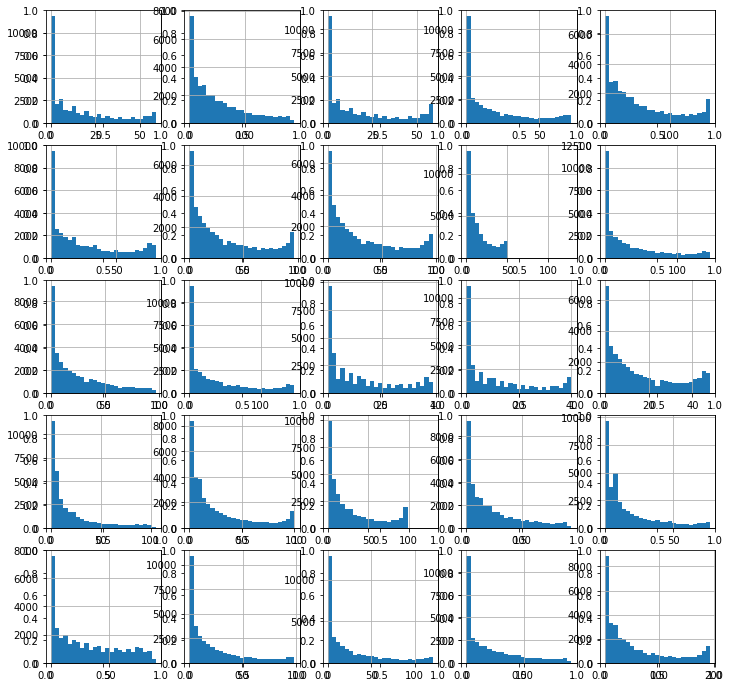

In [6]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize = (12,12))
for i, stn in enumerate(wind_farm_stns_df['station_name']):
    ax1 = fig.add_subplot(5, 5, i+1)
    wind_power_df.loc[wind_power_df['station_name']==stn,'power_output'].hist(bins=25, ax = ax1);

In [7]:
# Load injested wind speed and direction data
def load_wind_wthr_data(years):
    metadf = pd.DataFrame(columns = ['station_id','station_name','latitude','longitude','elevation'])
    datadf = pd.DataFrame(columns = ['station_id','hour','temp','dew_point','pressure','wind_dir','wind_speed','date','datetime','station_name','latitude','longitude','elevation'])
    for year in years:
        # wind wthr station metadata
        df1 = pd.read_csv('3cleaned_weather_data/compiled_wind_wthr_station_metadata_' + str(year) + '.csv')
        df1.drop(columns=[
            'Unnamed: 0',
            'ncdc_station_id',
            'country_id',
            'airport_id',
            'begin',
            'end'],
            inplace=True)
        df1.rename(columns={'af_station_id':'station_id'}, inplace=True)
        

        # wind speed data
        df2 = pd.read_csv('3cleaned_weather_data/compiled_wind_speed_data_' + str(year) + '.csv')
        df2.loc[:,'date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d %H:%M:%S')
        df2.loc[:,'datetime'] = pd.to_datetime(df2['datetime'], format='%Y-%m-%d %H:%M:%S')
        df2.drop(columns=[
            'Unnamed: 0',
            'sky_conditions',
            'precip_1hr',
            'precip_6hr'],
            inplace=True)
        
        # set wind speed data > 3 stdevs above mean = 3*stdev
        avgspeed = df2['wind_speed'].mean()
        stdspeed = df2['wind_speed'].std()
        df2.loc[df2['wind_speed'] > (avgspeed + (3 * stdspeed)),'wind_speed'] = avgspeed + (3 * stdspeed)
        
        # remove stations that don't contain wind speed data (by std(wind_speed) < 1)
        rmvdf = df2.groupby('station_id')['wind_speed','wind_dir'].std()
        rmvdf.reset_index(inplace=True)
        rmvdf = list(rmvdf.loc[rmvdf['wind_speed']>1,'station_id'].values)
        
        df1 = df1[df1['station_id'].isin(rmvdf)]
        df2 = df2[df2['station_id'].isin(rmvdf)]
        
        # set index for joining purposes
        df1.set_index('station_id', inplace=True)
        df2.set_index('station_id', inplace=True)

        # Join em up
        df2 = df2.join(df1).reset_index()
        df1.reset_index(inplace=True)
        metadf = pd.concat((metadf, df1), axis=0)
        datadf = pd.concat((datadf, df2), axis=0)
    
    # filter to those stations that contain data for all four years
    nentries = metadf.groupby('station_id')['latitude'].count().max()
    stations = metadf.groupby('station_id')['latitude'].agg({
                                              'latitude': lambda x: x.count().max()})
    stations = list(stations.loc[stations['latitude']==nentries].index)
    true_metadf = metadf[metadf['station_id'].isin(stations)]
    true_metadf = true_metadf.drop_duplicates()
    true_datadf = datadf[datadf['station_id'].isin(stations)]
    
    return true_metadf, true_datadf

In [8]:
wind_wthr_stns_df, wind_speed_df = load_wind_wthr_data(years)

C:\Users\alacroix367\Miniconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [9]:
display(wind_wthr_stns_df.head(3))
display(wind_speed_df.head(3))
print(wind_wthr_stns_df.shape)
print(wind_speed_df.shape)

,station_id,station_name,latitude,longitude,elevation
0,710630,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
1,711610,BROCKVILLE CLIMATE,44.633,-75.733,120.0
2,711710,VINELAND STATION RCS O,43.183,-79.400,79.0


,station_id,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,station_name,latitude,longitude,elevation
0,710630,0.0,18.86,5.18,101.64,220.0,11.4087,2015-01-01,2015-01-01 00:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
1,710630,1.0,18.86,4.28,101.56,230.0,13.8694,2015-01-01,2015-01-01 01:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
2,710630,2.0,18.32,5.36,101.49,230.0,13.8694,2015-01-01,2015-01-01 02:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0


(62, 5)
(2173968, 13)


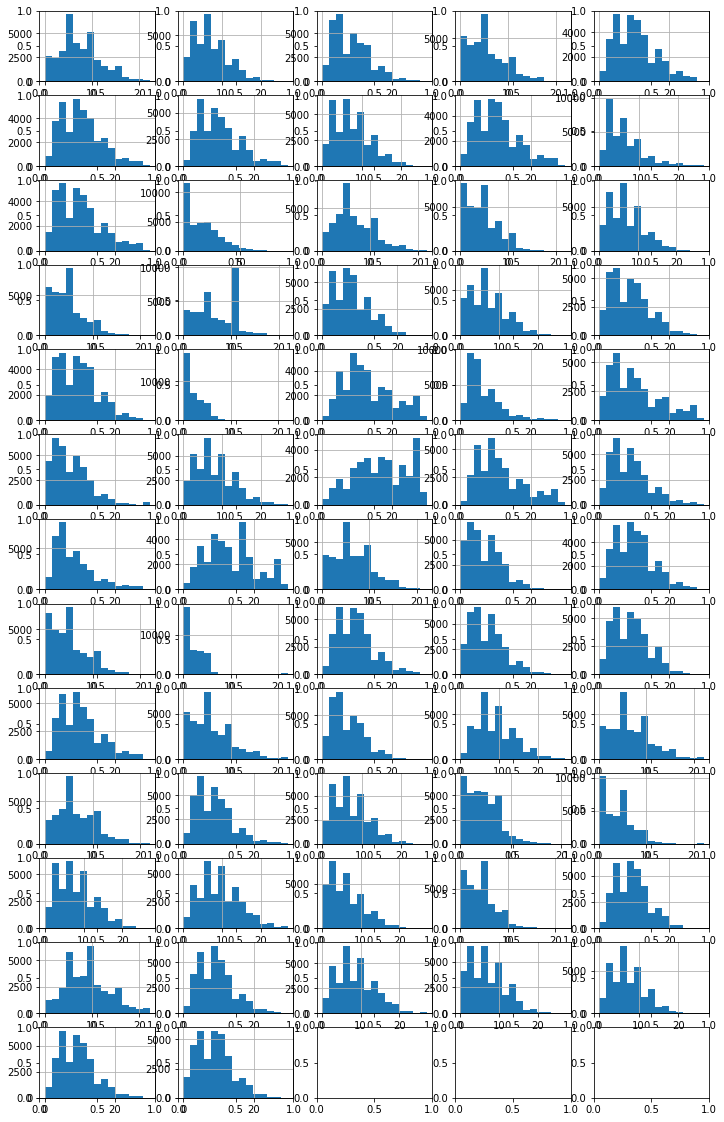

In [10]:
fig, ax = plt.subplots(nrows=13, ncols=5, figsize = (12,20))
for i, stn in enumerate(wind_wthr_stns_df['station_name']):
    ax1 = fig.add_subplot(13, 5, i+1)
    wind_speed_df.loc[wind_speed_df['station_name']==stn,'wind_speed'].hist(bins=15, ax = ax1);

In [11]:
# Find nearest neighbor according to 
# https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates
# ROUGH - should come up with my own spation.KDTree().query(pt) function to take in latitude and longitude type data
# OK ESTIMATE since we are looking in a relatively small corner of the world (I can be a flat earther for a bit!)
A = wind_farm_stns_df.loc[:,['latitude','longitude']].values
B = wind_wthr_stns_df.loc[:,['latitude','longitude']].values
inds = [spatial.KDTree(B).query(A[pt])[1] for pt in range(len(A))]
dists = [spatial.KDTree(B).query(A[pt])[0] for pt in range(len(A))]
miledists = [d*69 for d in dists] # convert to miles

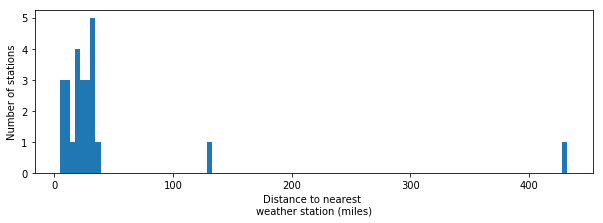

In [22]:
# appears that some wind farms don't really have reliable weather station data close by
# use this as exclusion criteria later (exclude those with dist>50 miles)
f,ax = plt.subplots(figsize=(10,3))
plt.hist(miledists,bins=100)
ax.set_xlabel('Distance to nearest \nweather station (miles)')
ax.set_ylabel('Number of stations')
plt.show();

In [13]:
# create dict of key:value pairs for wind farm : [weather_station, distance-to-weather-station] pairings
pairs = {}
for f, farm in enumerate(wind_farm_stns_df.loc[:,'station_name']):
    pairs[farm] = [wind_wthr_stns_df.loc[inds[f],'station_id'], miledists[f]]

print(pairs)
# make pairs into a data frame for joining
tmp0 = pd.DataFrame(pd.DataFrame(pairs).iloc[0,:].astype(int))
tmp1 = pd.DataFrame(pd.DataFrame(pairs).iloc[1,:])
pairs = pd.concat((tmp0,tmp1),axis=1)
pairs.columns=['station_id','distance']
pairs.reset_index(inplace=True)
pairs.set_index('station_id', inplace=True)
display(pairs.head(5))

# joining with wind_speed_df with same index
wind_speed_df.set_index('station_id', inplace=True)
display(wind_speed_df.head(5))

{'ADELAIDE': [716210, 33.434798104477224], 'AMARANTH': [716300, 12.352403537717908], 'BLAKE': [716210, 30.46797958699267], 'BORNISH': [716210, 36.20118349795986], 'COMBER': [712980, 25.80747985517707], 'DILLON': [713070, 4.899885841036441], 'EAST LAKE': [713070, 33.60289502894593], 'ERIEAU': [713070, 6.910959820447762], 'GOSFIELDWGS': [712980, 5.553925050671893], 'GRANDWF': [712630, 21.83066391533236], 'GREENWICH': [714620, 432.25756013788794], 'JERICHO': [717330, 30.59347477083314], 'KINGSBRIDGE': [712610, 11.271477305945368], 'LANDON': [711610, 30.335819975998685], 'PAROCHES': [713070, 34.28522083180357], 'PORT BURWELL': [715380, 22.29669505440237], 'PORTALMA-T1': [713070, 33.26183544031249], 'PORTALMA-T3': [713070, 21.925250436034183], 'PRINCEFARM': [714620, 130.51261520347055], 'RIPLEY SOUTH': [712610, 28.011198601413533], 'SHANNON': [717460, 13.703093820892617], 'SPENCE': [713070, 21.096862409108304], 'SUMMERHAVEN': [712630, 23.01111698381222], 'UNDERWOOD': [716310, 18.74014538179

,index,distance
station_id,,
716210,ADELAIDE,33.434798
716300,AMARANTH,12.352404
716210,BLAKE,30.467980
716210,BORNISH,36.201183
712980,COMBER,25.807480


,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,station_name,latitude,longitude,elevation
station_id,,,,,,,,,,,,
710630,0.0,18.86,5.18,101.64,220.0,11.4087,2015-01-01,2015-01-01 00:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,1.0,18.86,4.28,101.56,230.0,13.8694,2015-01-01,2015-01-01 01:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,2.0,18.32,5.36,101.49,230.0,13.8694,2015-01-01,2015-01-01 02:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,3.0,18.32,7.70,101.36,220.0,11.4087,2015-01-01,2015-01-01 03:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0
710630,4.0,19.22,5.72,101.26,220.0,13.8694,2015-01-01,2015-01-01 04:00:00,OTTAWA CDA RCS ONT,45.383,-75.717,79.0


In [14]:
# Join and do some final cleaning up of column names and data to exclude
final_wthr_df = wind_speed_df.join(pairs).reset_index()
final_wthr_df.dropna(inplace=True)
final_wthr_df.reset_index(inplace=True)
final_wthr_df.drop(columns='level_0', inplace=True)
final_wthr_df.rename(columns={'station_name':'weather_station_name'}, inplace=True)
final_wthr_df.rename(columns={'index':'station_name'}, inplace=True)
final_wthr_df = final_wthr_df.loc[final_wthr_df['distance']<=50,:]
display(final_wthr_df.head(10))

,station_id,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,datetime,weather_station_name,latitude,longitude,elevation,station_name,distance
0,711610,0.0,19.04,11.12,101.73,240.0,13.8694,2015-01-01,2015-01-01 00:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
1,711610,1.0,18.86,11.30,101.66,250.0,13.8694,2015-01-01,2015-01-01 01:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
2,711610,2.0,18.50,7.70,101.60,260.0,11.4087,2015-01-01,2015-01-01 02:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
3,711610,3.0,18.50,4.82,101.48,250.0,11.4087,2015-01-01,2015-01-01 03:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
4,711610,4.0,18.86,4.82,101.38,240.0,10.2902,2015-01-01,2015-01-01 04:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
5,711610,5.0,19.58,5.18,101.31,250.0,10.2902,2015-01-01,2015-01-01 05:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
6,711610,6.0,19.76,10.58,101.26,250.0,14.9879,2015-01-01,2015-01-01 06:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
7,711610,7.0,20.30,10.58,101.23,240.0,13.8694,2015-01-01,2015-01-01 07:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
8,711610,8.0,22.10,7.34,101.19,230.0,12.7509,2015-01-01,2015-01-01 08:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582
9,711610,9.0,22.10,6.08,101.19,230.0,13.8694,2015-01-01,2015-01-01 09:00:00,BROCKVILLE CLIMATE,44.633,-75.733,120.0,LANDON,30.33582


In [15]:
pairs.reset_index(inplace=True)
pairs.rename(columns={'index':'station_name'}, inplace=True)
pairs.set_index('station_name', inplace=True)
wind_power_df.set_index('station_name', inplace=True)
display(wind_power_df.head())

,hour,date,datetime,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output,latitude,longitude
station_name,,,,,,,,,,
ADELAIDE,0,2015-01-01,2015-01-01 00:00:00,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304
ADELAIDE,1,2015-01-01,2015-01-01 01:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304
ADELAIDE,2,2015-01-01,2015-01-01 02:00:00,56.0,55.0,59.0,0.949153,0.932203,43.100099,-81.634304
ADELAIDE,3,2015-01-01,2015-01-01 03:00:00,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304
ADELAIDE,4,2015-01-01,2015-01-01 04:00:00,58.0,58.0,59.0,0.983051,0.983051,43.100099,-81.634304


In [16]:
# Join and do some final cleaning up of column names and data to exclude
final_farm_df = wind_power_df.join(pairs).reset_index()
final_farm_df.interpolate(inplace=True)
final_farm_df = final_farm_df.loc[final_farm_df['distance']<=50,:]
display(final_farm_df.head(10))

,station_name,hour,date,datetime,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output,latitude,longitude,station_id,distance
0,ADELAIDE,0,2015-01-01,2015-01-01 00:00:00,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304,716210,33.434798
1,ADELAIDE,1,2015-01-01,2015-01-01 01:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798
2,ADELAIDE,2,2015-01-01,2015-01-01 02:00:00,56.0,55.0,59.0,0.949153,0.932203,43.100099,-81.634304,716210,33.434798
3,ADELAIDE,3,2015-01-01,2015-01-01 03:00:00,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304,716210,33.434798
4,ADELAIDE,4,2015-01-01,2015-01-01 04:00:00,58.0,58.0,59.0,0.983051,0.983051,43.100099,-81.634304,716210,33.434798
5,ADELAIDE,5,2015-01-01,2015-01-01 05:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798
6,ADELAIDE,6,2015-01-01,2015-01-01 06:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798
7,ADELAIDE,7,2015-01-01,2015-01-01 07:00:00,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798
8,ADELAIDE,8,2015-01-01,2015-01-01 08:00:00,59.0,58.0,59.0,1.000000,0.983051,43.100099,-81.634304,716210,33.434798
9,ADELAIDE,9,2015-01-01,2015-01-01 09:00:00,59.0,59.0,59.0,1.000000,1.000000,43.100099,-81.634304,716210,33.434798


In [17]:
print(final_wthr_df.shape)
print(final_farm_df.shape)

(806472, 15)
(806472, 13)


In [1]:
# Overlay windspeed and energy production vs time
# Inputs
stn = 'AMARANTH'
# stn = 'LANDON'

# wthr_stn = int(pairs[farm_stn][0]) # with station_id
start_date  = dt.datetime(2018, 4, 29)
end_date = dt.datetime(2018, 4, 25)

# Create fig
f,ax = plt.subplots(figsize=(12,4))

# Create tmp dataframes
# actual & predicted wind power
pwr_df = final_farm_df.loc[
    (final_farm_df['datetime']>start_date) & 
    (final_farm_df['datetime']<end_date) & 
    (final_farm_df['station_name']==stn)]
# wind speed
spd_df = final_wthr_df.loc[
    (final_wthr_df['datetime']>start_date) & 
    (final_wthr_df['datetime']<end_date) & 
    (final_wthr_df['station_name']==stn)]

sns.lineplot(x='datetime', y='pmax_power_output', data=pwr_df, color="#9b59b6")
sns.lineplot(x='datetime', y='pred_pmax_power_output', data=pwr_df, color="#9b59b6", alpha=0.5)
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.lineplot(x='datetime', y='wind_speed', data=spd_df, color="#3498db", ax=ax2)

ax.set_xlim([start_date,end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Power Generation at\n' + stn + ' wind farm (MW)', color="#9b59b6")
ax2.set_ylabel('Wind Speed (mph)', color="#3498db")
plt.savefig(stn + '.png',dpi=500);

NameError: name 'dt' is not defined

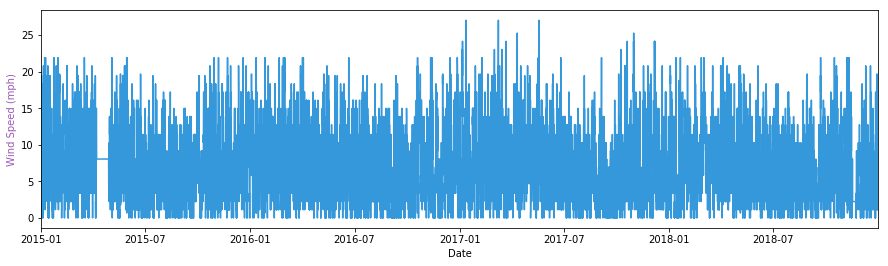

In [19]:
# Just look at windspeed
stn = 'LANDON'
start_date  = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2018, 12, 31)

# Create fig
f,ax = plt.subplots(figsize=(15,4))

# Create tmp dataframes
# wind speed
tmp_wind_speed_df = final_wthr_df.loc[
    (final_wthr_df['datetime']>start_date) & 
    (final_wthr_df['datetime']<end_date) & 
    (final_wthr_df['station_name']==stn)]

sns.lineplot(x='datetime', y='wind_speed', data=tmp_wind_speed_df, color="#3498db")

ax.set_xlim([start_date,end_date])
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed (mph)', color="#9b59b6")
plt.savefig(stn + '.png',dpi=500);

In [20]:
print(len(final_wthr_df.groupby('station_name').count()))
print(len(final_farm_df.groupby('station_name').count()))

23
23


In [21]:
# save compiled data from 2015 to 2018 in individual files
final_wthr_df.to_csv('final_weather_data_2015to2018.csv')
final_farm_df.to_csv('final_power_data_2015to2018.csv')